Prerequisite: the reader is encouraged to read the documentation of `expression` and `locationdb` before this part.

# Miasm Intermediate representation
The intermediate representation of Miasm allows to represent the `side effects` of instructions in a control flow graph. To summarise, here is the correspondence between native world and its intermediate representation:
- an assembly control flow graph (`AsmCFG`) is represented in intermediate representation by an "Intermediate representation control flow graph": `IRCfg`
- an AsmCFG in composed of basic blocks. In intermediate representation, the `IRCfg` is composed of Intermediate representation blocks: `IRBlock`s
- a native basic block is a sequence of instructions. In intermediate representation, the `IRBlock` if a sequence of `AssignBlock`s
- an `AssignBlock` is composed of parallel assignments of expressions. "Parallel" mean that those assignments are executed exactly the same time (different from successive)

Note this does not imply that an instruction translates to an `AssignBlock`. The translation of a native instruction can generate multiple `AssignBlock`s and even multiple `IRBlock`s. 

# Examples
Let's take some examples of translated instructions. First of all, we will create an helper to generate intermediate representation from assembly code. Skip this code, it's not important for the rest of the documentation

In [1]:
from miasm.analysis.machine import Machine
from miasm.arch.x86.arch import mn_x86
from miasm.core import parse_asm, asmblock
from miasm.arch.x86.lifter_model_call import LifterModelCall_x86_32
from miasm.core.locationdb import LocationDB
from miasm.loader.strpatchwork import StrPatchwork
from miasm.analysis.binary import Container
from miasm.ir.ir import IRCFG, AssignBlock
from miasm.expression.expression import *
import logging

# Quiet warnings
asmblock.log_asmblock.setLevel(logging.ERROR)


def gen_x86_asmcfg(asm):
    # First, asm code
    machine = Machine("x86_32")

    # Add dummy label "end" at code's end
    code = asm + "\nend:\n"
    loc_db = LocationDB()
    # The main will be at address 0
    loc_db.set_location_offset(loc_db.get_or_create_name_location("main"), 0x0)

    asmcfg = parse_asm.parse_txt(
        mn_x86, 32, code,
        loc_db
    )
    virt = StrPatchwork()
    # Assemble shellcode
    patches = asmblock.asm_resolve_final(
        machine.mn,
        asmcfg,
    )
    # Put shelcode in a string
    for offset, raw in patches.items():
        virt[offset] = raw
    data = bytes(virt)
    cont = Container.fallback_container(
        data,
        vm=None, addr=0,
        loc_db=loc_db,
    )
    dis_engine = machine.dis_engine
    # Disassemble back the shellcode
    # Now, basic blocks are at known position, determined by
    # the assembled version
    mdis = dis_engine(cont.bin_stream, loc_db=cont.loc_db)
    asmcfg = mdis.dis_multiblock(0)
    return asmcfg

def lift_x86_asm(asm, model_call=False, lifter_custom=None):
    asmcfg = gen_x86_asmcfg(asm)
    machine = Machine("x86_32")
    # Get a lifter
    if model_call and lifter_custom is None:
        lifter = LifterModelCall_x86_32(asmcfg.loc_db)
    elif lifter_custom is not None:
        lifter = lifter_custom(asmcfg.loc_db)
    else:
        lifter = machine.lifter(asmcfg.loc_db)

    # Translate to IR
    ircfg = lifter.new_ircfg_from_asmcfg(asmcfg)
    return ircfg

def graph_ir_x86(asm, model_call=False, lifter_custom=None):
    ircfg = lift_x86_asm(asm, model_call, lifter_custom)
    return ircfg.graphviz()


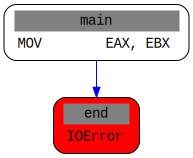

In [2]:
# Let's generate the AsmCFG
asmcfg = gen_x86_asmcfg("""
main:
    MOV EAX, EBX
""")
asmcfg.graphviz()

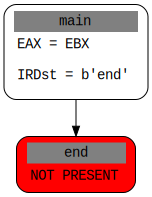

In [3]:
# And graph the corresponding IRCFG
graph_ir_x86("""
main:
    MOV EAX, EBX
""")

Lets analyze this graph:
- the first ir basic block has the name set to `main`
- it is composed of 2 `AssignBlock`s
- the first `AssignBlock` contains only one assignment, `EAX = EBX`
- the second one is `IRDst = loc_key_1`

The `IRDst` is a special register which represent a kind of *program counter* in intermediate representation. Each `IRBlock` has one and only one assignment to `IRDst`. The position of the `IRDst` assignment is not always in the last `AssignBlock` of the `IRBlock`. In our case, the shellcode stops after the `MOV EAX, EBX`, so the next location to execution is unknown: `end`. This label has been artificially added by the script.


Let's take another instruction.

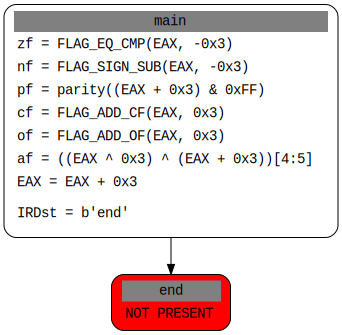

In [4]:
graph_ir_x86("""
main:
    ADD EAX, 3
""")

In this graph, we can note that each instruction side effect is represented.
Note that in the equation:
```
zf = FLAG_EQ_CMP(EAX, -0x3)
```
The detailed version of the expression:
```
ExprId('zf', 1) = ExprOp('FLAG_EQ_CMP', ExprId('EAX', 32), ExprInt(-0x3, 32))
```
The operator `FLAG_EQ_CMP` is a kind of *high level* representation. But you can customize the lifter in order to get the real equation of the `zf`. This will be presented in a documentation dedicated to modification of the intermediate representation control flow graph.
```
ExprId('zf', 1) = ExprCond(ExprId('EAX', 32) - ExprInt(-0x3, 32), ExprInt(0, 1), ExprInt(1, 1))
```
which is, in a simplified form:
```
zf = (EAX - 3) ? (0, 1)
```

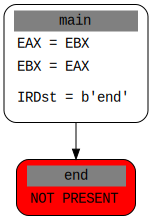

In [5]:
graph_ir_x86("""
main:
    XCHG EAX, EBX
""")

This one is interesting, as it demonstrate perfectly the parallel execution of multiple assignments. In you are puzzled by this notation, imagine this describes equations, which expresses destination variables of an output state depending on an input state. The equations can be rewritten:
```
EAX_out = EBX_in
EBX_out = EAX_in
```

And this matches the `xchg` semantic. After the execution, those variables are committed, which means that `EAX` takes the value of `EAX_out`, and `EBX` takes the value of `EBX_out`

Some arbitrary choices have been done in order to try to match as best as possible. For example lets take the instruction:
```
CMOVZ EAX, EBX
```
This conditional move is done if the zero flag is activated. So we may want to translate it as:
```
EAX = zf ? EBX : EAX
```
Which can be read: if `zf` is 1, `EAX` is set to `EBX` else `EAX` is set to `EAX`, which is equivalent to no modifications.

This representation seems good at first, as the semantic of the conditional move seems ok. But let's question the system on the equation `EAX = zf ? EBX, EAX`:
- which register is written ? `EAX` is *always* written
- which register is read ? `zf`, `EBX`, `EAX` are read

IF we ask the same question on the instruction `CMOVZ EAX, EBX`, the answers are a bit different:
- which register is written ? `EAX` is written only if the `zf` is 1
- which register is read ? `zf` is *always* read, `EBX` may be read is `zf` is 1

The conclusion is the representation we gave doesn't represent properly the instruction. Here is what Miasm will gave as intermediate representation for it:

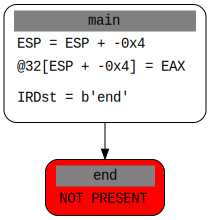

In [6]:
# Here is a push
graph_ir_x86("""
main:
    PUSH EAX
""")

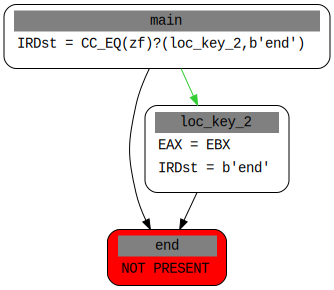

In [7]:
graph_ir_x86("""
main:
    CMOVZ EAX, EBX
""")

Here are some remarks we can do on this version:
- *one* x86 instruction has generated multiple `IRBlocks`
- the first `IRBlock` only reads the `zf` (we don't take the locations into account here)
- `EAX` is assigned only in the case of `zf` equals to 1
- `EBX` is read only in the case of `zf` equals to 1

We can dispute on the fact that in this form, it's harder to get what is read and what is written. But one argument is: If `cmovz` doesn't exist (for example in older cpus) what may be the code to do this ?

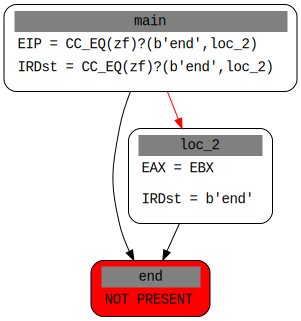

In [8]:
graph_ir_x86("""
main:
    JZ    end
    MOV   EAX, EBX
end:
""")

The conclusion is that in intermediate representation, the `cmovz` is exactly as difficult as analyzing the code using `jz/mov`

So an important point is that in intermediate representation, one instruction can generate *multiple* `IRBlock`s. Here are some interesting examples:

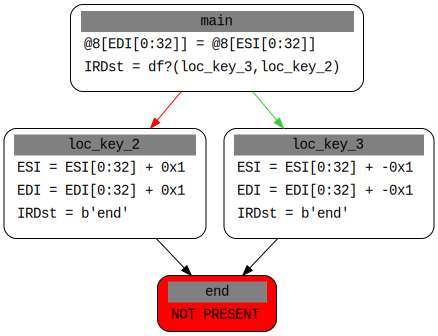

In [9]:
graph_ir_x86("""
main:
    MOVSB
""")

And now, the version using a repeat prefix:

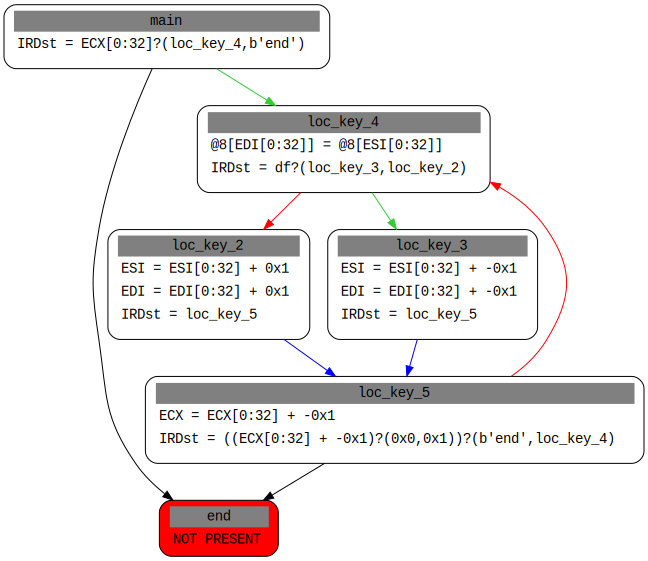

In [10]:
graph_ir_x86("""
main:
    REP MOVSB
""")

In the very same way as `cmovz`, if the `rep movsb` instruction didn't exist, we would use a more complex code.

The translation of some instructions are tricky:

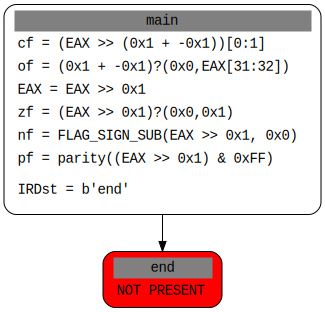

In [11]:
graph_ir_x86("""
main:
    SHR EAX, 1
""")

For the moment, nothing special. `EAX` is updated correctly, and the flags are updated according to the result (note those side effects are in parallel here). But look at the next one:

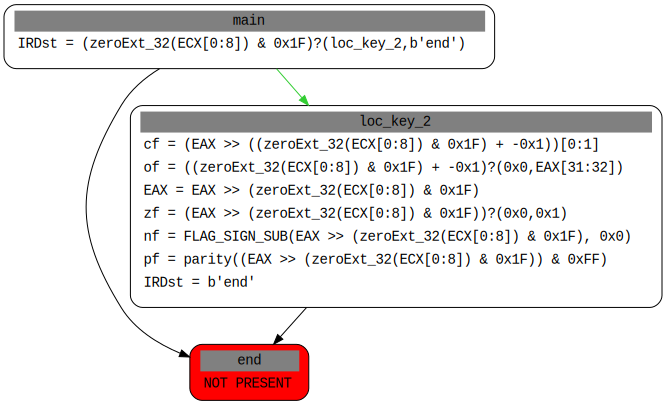

In [12]:
graph_ir_x86("""
main:
    SHR EAX, CL
""")

In this case, if `CL` is zero, the destination is shifted by a zero amount. The instruction behaves (in 32 bit mode) as a `nop`, and the flags are not assigned. We could have done the same trick as in the `cmovz`, but this representation matches more accurately the instruction semantic.

Here is another one:

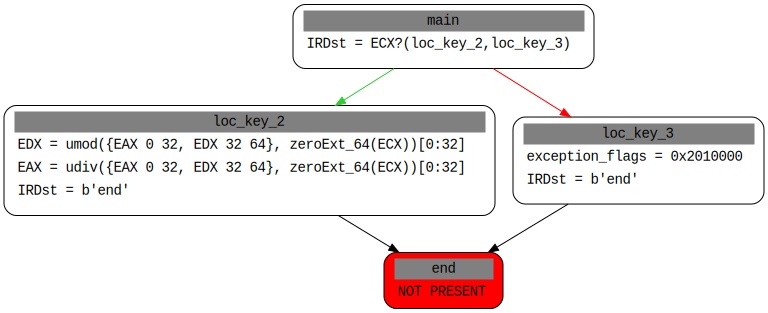

In [13]:
graph_ir_x86("""
main:
    DIV ECX
""")

This instruction may generate an exception in case of the divisor is zero. The intermediate representation generates a test in which it evaluate the divisor value and assigns a special register `exception_flags` to a constant. This constant represents the division by zero.

Note this is arbitrary. We could have done the choice to not explicit the possible division by zero, and keep in mind that the `umod` and `udiv` operator may generate exceptions. This may change in a future version of Miasm. Indeed, each memory access may generate a exception, and Miasm doesn't explicit them in the intermediate representation: this may be misleading and very hard to analyze in a post pass. This is why we may accept to implicitly raise exception in both those operators rather than generating such a code.

The same choice has been done in other instructions:

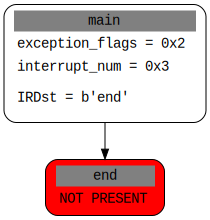

In [14]:
graph_ir_x86("""
main:
    INT 0x3
""")

Memory accesses by default explicit segmentation:

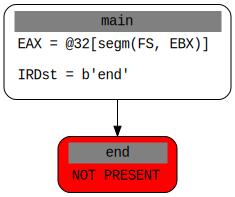

In [15]:
graph_ir_x86("""
main:
    MOV EAX, DWORD PTR FS:[EBX]
""")

The pointer of the memory uses the special operator `segm`, which takes two arguments:
- the value of the segment used the memory access
- the base address

Note that if you work in a flat segmentation model, you can add a post translation pass which will *simplify* `ExprOp("segm", A, B)` into `B`. This will ease code analysis.

Note: If you read carefully the documentation on `expression`s, you know that the word `ExprOp` is n-ary and that all of its arguments must have the same size. The operator `segm` is one of the exceptions. The register `FS` has a size of 16 bit (as a segment selector register) and `EBX` has a size of 32. In this case, the size of `ExprOp("segm", FS, EBX)` has the size of `EBX`

# Intermediate representation translation
In this part, we will explain some manipulations which can be done during the native code *lifting*. Let's take the example of a call to a subfunction:

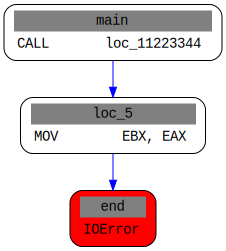

In [16]:
asmcfg = gen_x86_asmcfg("""
main:
    CALL 0x11223344
    MOV EBX, EAX
""")
asmcfg.graphviz()

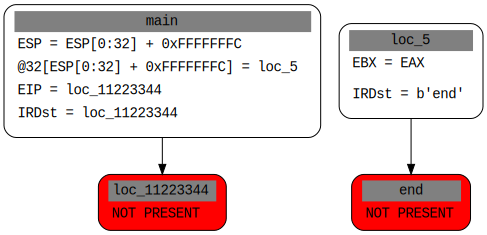

In [17]:
graph_ir_x86("""
main:
    CALL 0x11223344
    MOV EBX, EAX
""")

What did happened here ?
- the `call` instruction has 2 side effects: stacking the return address and jumping to the subfunction address
- here, the subfunction address is 0x1122334455, and the return address is located at offset `0x5`, which is represented here by `loc_5`

The question is: why are there unlinked nodes in the graph? The answer is that the graph only analyzes destinations of the `IRBlock`s, which means the value of `IRDst`. So in the `main`, Miasm knowns that the next `IRBlock` is located at `loc_11223344`. But as we didn't disassemble code at this address, we don't have its intermediate representation.

But the disassembler engine knowns (this behavior can be customized) that a `call` returns back to the instruction just next to the call. So the basic block at `end` has been disassembled and translated. If we analyze `IRDst` only, there are no links between them.

This `raw` way of translating is interesting to see low level moves of stack and return address, but it makes code analysis a bit hard. What we may want is to consider subcalls like an unknown operator, with arguments and side effects. This may *model* the call to a subfunction.

This is the difference in Miasm between translating using `lifter` (raw translation) and `lifter_model_call` (`ilifter` + call modelization) which models subfunction calls. By default, Miasm uses a basic model which is *wrong* in most cases. But this model can (and must ?) be replaced by the user behavior.

You can observe the difference in the examples:
```
example/disasm/dis_binary_lift.py
```
and
```
example/disasm/dis_binary_lifter_model_call.py
```


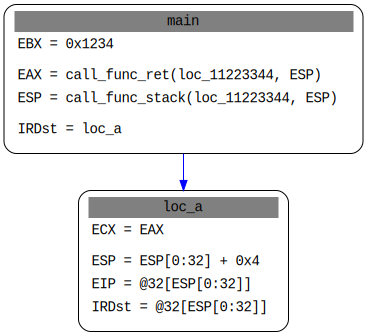

In [18]:
graph_ir_x86("""
main:
    MOV  EBX, 0x1234
    CALL 0x11223344
    MOV  ECX, EAX
    RET
""", True)

What happened here?
The translation of the `call` is replaced by two side effects which occur in parallel:
- `EAX` is set to the result of the operator `call_func_ret` which has two arguments: `loc_11223344` and `ESP`
- `ESP` is set to the result of the operator `call_func_stack` which has two arguments: `loc_11223344` and `ESP`

The first one is there to model the assignment in 'classic' x86 code of the return value. The second one is there to model a possible change of the stack pointer depending on the function called, that the old stack pointer.
Everything here can be subclassed in order to customize the translation behavior.

# Subfunction call custom modeling
The code responsible of the modelisation of function calls is located in the `LifterModelCall` class (the lifter with call modeling) in `miasm/ir/analysis.py`:
```python
...
    def call_effects(self, addr, instr):
        """Default modelisation of a function call to @addr. This may be used to:

        * insert dependencies to arguments (stack base, registers, ...)
        * add some side effects (stack clean, return value, ...)

        Return a couple:
        * list of assignments to add to the current irblock
        * list of additional irblocks

        @addr: (Expr) address of the called function
        @instr: native instruction which is responsible of the call
        """

        call_assignblk = AssignBlock(
            [
                ExprAssign(self.ret_reg, ExprOp('call_func_ret', addr, self.sp)),
                ExprAssign(self.sp, ExprOp('call_func_stack', addr, self.sp))
            ],
            instr
        )
        return [call_assignblk], []

```

Some architectures subclass it to include some architecture dependent stuffs, for example in `miasm/arch/x86/lifter_model_call.py` in which we use a default calling convention linked to arguments passed through registers:
```python
...
    def call_effects(self, ad, instr):
        call_assignblk = AssignBlock(
            [
                ExprAssign(
                    self.ret_reg,
                    ExprOp(
                        'call_func_ret',
                        ad,
                        self.sp,
                        self.arch.regs.RCX,
                        self.arch.regs.RDX,
                        self.arch.regs.R8,
                        self.arch.regs.R9,
                    )
                ),
                ExprAssign(self.sp, ExprOp('call_func_stack', ad, self.sp)),
            ],
            instr
        )
        return [call_assignblk], []

```

This is the generic code used in `x86_64` to model function calls. But you can finely model functions. For example, suppose you are analysing code on `x86_32` with `stdcall` convention. Suppose you know the callee clean its stack arguments. Supppose as well you know for each function how many arguments it has. You can then customize the model to match the callee and compute the correct stack modification, as well as getting the arguments from stack:





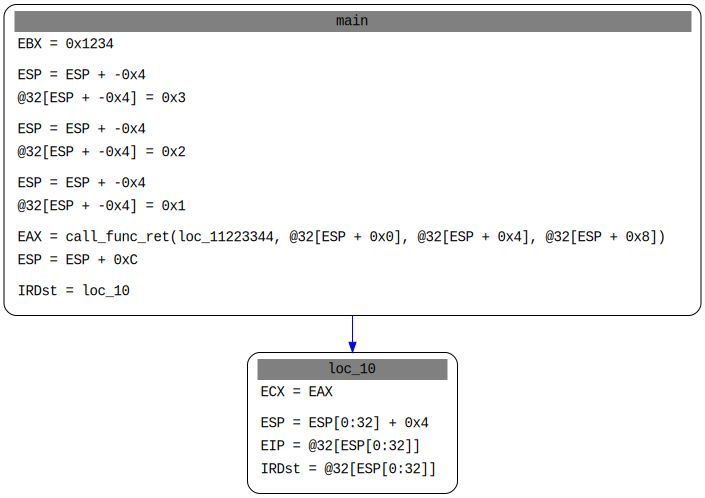

In [19]:
# Construct a custom lifter
class LifterFixCallStack(LifterModelCall_x86_32):
        def call_effects(self, addr, instr):
            if addr.is_loc():
                if self.loc_db.get_location_offset(addr.loc_key) == 0x11223344:
                    # Suppose the function at 0x11223344 has 3 arguments
                    args_count = 3
                else:
                    # It's a function we didn't analyze
                    raise RuntimeError("Unknown function parameters")
            else:
                # It's a dynamic call !
                raise RuntimeError("Dynamic destination ?")
            # Arguments are taken from stack
            args = []
            for i in range(args_count):
                args.append(ExprMem(self.sp + ExprInt(i * 4, 32), 32))
            # Generate the model
            call_assignblk = AssignBlock(
                [
                    ExprAssign(self.ret_reg, ExprOp('call_func_ret', addr, *args)),
                    ExprAssign(self.sp, self.sp + ExprInt(args_count * 4, self.sp.size))
                ],
                instr
            )
            return [call_assignblk], []

graph_ir_x86("""
main:
    MOV  EBX, 0x1234
    PUSH 3
    PUSH 2
    PUSH 1
    CALL 0x11223344
    MOV  ECX, EAX
    RET
""", lifter_custom=LifterFixCallStack)

In the new graph, it's now easy to see that `EAX` depends on a custom operator `call_func_ret` with arguments:
- `loc_11223344`
- @32[ESP + 0x0]
- @32[ESP + 0x4]
- @32[ESP + 0x8]

The stack pointer is updated: it is increased by 0xC bytes, which corresponds to its arguments size (we didn't model the extra 4 bytes pushed on the stack for the return address, so no need to take them into account using our arbitrary model)
